In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
df_raw= pd.read_csv(f"D:\credit_risk_data\loan.csv")

C:\Users\Admin\AppData\Local\Temp\ipykernel_26188\1572992421.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw= pd.read_csv(f"D:\credit_risk_data\loan.csv")


In [51]:
#drop columns having na rate > 75%
na_rates = df_raw.isna().sum()/len(df_raw)
drop_columns = na_rates[na_rates > 0.75].index
df_raw.drop(columns = drop_columns, inplace = True)

In [52]:
df_raw.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

In [53]:
df = df_raw[['member_id', 'loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'grade',
          'emp_length', 'home_ownership', 'addr_state', 'annual_inc', 'purpose',
          'dti', 'delinq_2yrs', 'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'loan_status']]

## Data cleaning

In [54]:
df = df[((df.loan_status == 'Current') | (df.loan_status == 'Charged Off') | (df.loan_status == 'Default'))]
len(df)

648246

In [55]:
for i in df['loan_status'].unique():
    if (i == 'Current'):
        df['loan_status'].replace({i:"Not Default"}, inplace = True)
    else:
        df['loan_status'].replace({i:"Default"}, inplace = True)
loan_status_frequency = df['loan_status'].value_counts().sort_index()

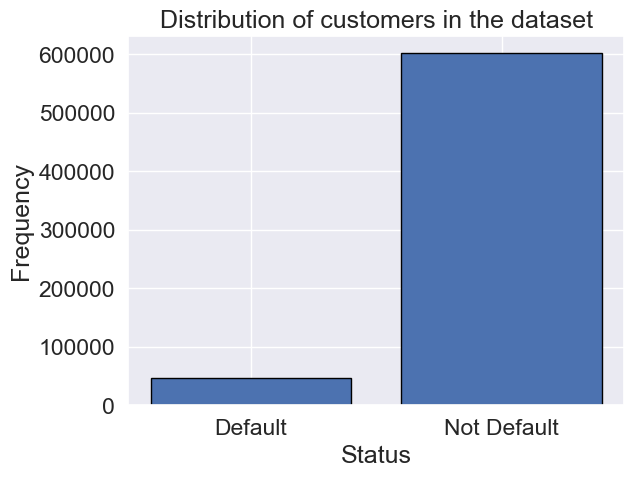

In [56]:
loan_status_frequency = df['loan_status'].value_counts().sort_index()

plt.bar(loan_status_frequency.index, loan_status_frequency.values, width=0.8, edgecolor= 'black')
plt.xlabel("Status")
plt.ylabel("Frequency")
plt.title("Distribution of customers in the dataset")
plt.show()

In [57]:
# convert target variable to binary
for i in df['loan_status'].unique():
    if (i == 'Default'):
        df['loan_status'].replace({i:1}, inplace = True)
    else:
        df['loan_status'].replace({i:0}, inplace = True)

In [58]:
df['term'] = df.term.astype('str').map(lambda x: x[:3])

In [59]:
df.isna().sum()
#Since the number of missing values in annual_inc, delinq_2yrs, total_acc is very low compared to the length of the dataset, we can remove it
df.dropna(subset = ['annual_inc', 'delinq_2yrs', 'total_acc'], inplace = True)

In [60]:
df.isna().sum() 

member_id              0
loan_amnt              0
funded_amnt_inv        0
term                   0
int_rate               0
grade                  0
emp_length         35689
home_ownership         0
addr_state             0
annual_inc             0
purpose                0
dti                    0
delinq_2yrs            0
total_acc              0
tot_coll_amt       13624
tot_cur_bal        13624
loan_status            0
dtype: int64

##### There is no evidence to deal with missing values in emp_length, tot_coll_amt, tot_cur_bal columns, we can try to replace missing values by WOE values

## Single factor analysis

In [61]:
from sklearn.model_selection import train_test_split
target = 'loan_status'
model_features = list(set(df.columns).difference({target}))

X = df[model_features]
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42, stratify=df['loan_status'])

In [62]:
import pandas as pd

def binning(train_set, test_set, columns_to_bin, nbins, keep_missing = True):
    '''
    train_set: training set
    test_set: test set
    columns_to_bin: declare column need to be binned
    nbins: number of bins 
    keep_missing: False for replace missing value by 'missing' and True for keep 
    '''
    
    train_binned = pd.DataFrame()
    test_binned = pd.DataFrame()

    for col in columns_to_bin:
        coltype = df[col].dtype
        if coltype in ['float', 'int']:
            # Get the bin labels and bin edges from pd.qcut on the training set
            bin_labels, bin_edges = pd.qcut(train_set[col], nbins, retbins=True, duplicates='drop', labels=None)

            # Use the same bin edges to bin the test set and assign the same labels
            train_binned[f'{col}_binned'] = pd.cut(train_set[col], bins=bin_edges, include_lowest=True, labels=bin_labels.cat.categories)
            test_binned[f'{col}_binned'] = pd.cut(test_set[col], bins=bin_edges, include_lowest=True, labels=bin_labels.cat.categories)

        else:
            train_binned[f'{col}'] = train_set[col]
            test_binned[f'{col}'] = test_set[col]
    train_binned = pd.DataFrame(train_binned)
    test_binned = pd.DataFrame(test_binned)
    
    if not keep_missing:
        for colname in train_binned.columns:
                train_binned[colname] = train_binned[colname].astype(object)
                test_binned[colname] = test_binned[colname].astype(object)

                # Fill missing values with 'missing'
                train_binned[colname].fillna('missing_value', inplace=True)
                test_binned[colname].fillna('missing_value', inplace=True)

    return train_binned, test_binned


def WOE(train_set, colname, target_variable):
    train_set['loan_status'] = target_variable
    train_set[colname] = train_set[colname].astype(object)
    bin_table = train_set.groupby(colname).agg({'loan_status':['count','sum']})
    bin_table.index.names = ['Cut_point']
    bin_table.columns = ['Total', '#BAD']
    bin_table['#GOOD'] = bin_table['Total'] - bin_table['#BAD']
    bin_table['Per_bin(%)'] = (bin_table['Total']/bin_table['Total'].sum())* 100
    bin_table['Bad_rate'] = bin_table['#BAD']/bin_table['#BAD'].sum()
    bin_table['Good_rate'] = bin_table['#GOOD']/bin_table['#GOOD'].sum()
    bin_table['WOE'] = np.log((bin_table['Good_rate'])/(bin_table['Bad_rate']))
        
    return bin_table

def IV(train_set, colname, target_variable, threshold):
    IV_table = []
    for col in colname:
        try:        
            bin_table = WOE(train_set, col, target_variable)
            bin_table['IV'] = (bin_table['Good_rate'] - bin_table['Bad_rate'])*bin_table['WOE']
            IV_value = bin_table['IV'].sum()
        except:
            IV_value = np.inf
            
        IV_table.append(IV_value)
    IV_table = pd.DataFrame(IV_table, columns = ['IV'])
    IV_table.set_index(colname, inplace = True)
    IV_table = IV_table.sort_values('IV', ascending = False)
    IV_table = IV_table[IV_table['IV'] >= threshold]
    return IV_table
                            

def fit_WOE(train_set, test_set, column_name, target_variable):
    train_WOE = pd.DataFrame()
    test_WOE = pd.DataFrame()
    for feature in column_name:
        # Calculate WOE for quantile_bins
        bin_table = WOE(train_set, feature, target_variable)
        
        # Create a dictionary to map bin to WOE
        woe_map = bin_table['WOE'].to_dict()
        
        # Map the WOE values to the original data
        train_WOE[f'{feature}_woe'] = train_set[f'{feature}'].map(woe_map)
        test_WOE[f'{feature}_woe'] = test_set[f'{feature}'].map(woe_map)

    return train_WOE, test_WOE

In [63]:
train_binned, test_binned = binning(x_train, x_test, x_train.columns, 6, keep_missing = False)
train_binned.drop(columns = ['member_id'], inplace = True)
test_binned.drop(columns = ['member_id'], inplace = True)

In [64]:
IV_table = IV(train_binned, train_binned.columns, y_train, 0.015)
IV_table

C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,IV
home_ownership,inf
addr_state,inf
purpose,inf
tot_cur_bal_binned,0.826983
tot_coll_amt_binned,0.797679
int_rate_binned,0.525084
grade,0.279457
annual_inc_binned,0.074292
emp_length,0.017698


In [65]:
WOE(train_binned, 'purpose', y_train)

C:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Total,#BAD,#GOOD,Per_bin(%),Bad_rate,Good_rate,WOE
Cut_point,,,,,,,
car,4330,347,3983,0.834947,0.009334,0.008273,-0.120669
credit_card,126091,6456,119635,24.313917,0.173670,0.248503,0.358301
debt_consolidation,307851,22713,285138,59.362394,0.610992,0.592283,-0.031099
educational,41,41,0,0.007906,0.001103,0.000000,-inf
home_improvement,29719,1834,27885,5.730665,0.049336,0.057922,0.160455
house,1734,234,1500,0.334364,0.006295,0.003116,-0.703235
major_purchase,8915,724,8191,1.719065,0.019476,0.017014,-0.135135
medical,4703,461,4242,0.906872,0.012401,0.008811,-0.341743
moving,2858,358,2500,0.551103,0.009630,0.005193,-0.617622


In [67]:
# educational bin take WOE value as -inf, it should be merge to other bin
train_binned['purpose'].replace({'educational':'other'}, inplace = True)
test_binned['purpose'].replace({'educational':'other'}, inplace = True)

In [66]:
WOE(train_binned, 'home_ownership', y_train)

,Total,#BAD,#GOOD,Per_bin(%),Bad_rate,Good_rate,WOE
Cut_point,,,,,,,
ANY,2,0,2,0.000386,0.000000,0.000004,inf
MORTGAGE,259157,16233,242924,49.972811,0.436676,0.504597,0.144568
NONE,8,6,2,0.001543,0.000161,0.000004,-3.659747
OTHER,23,21,2,0.004435,0.000565,0.000004,-4.912510
OWN,52888,3304,49584,10.198305,0.088879,0.102995,0.147400
RENT,206518,17610,188908,39.822521,0.473718,0.392396,-0.188341


In [68]:
#ANY bin take WOE as inf, it should be merge to other bin
train_binned['home_ownership'].replace({'ANY':'OTHER'}, inplace = True)
test_binned['home_ownership'].replace({'ANY':'OTHER'}, inplace = True)

In [69]:
WOE(train_binned, 'addr_state', y_train)

,Total,#BAD,#GOOD,Per_bin(%),Bad_rate,Good_rate,WOE
Cut_point,,,,,,,
AK,1251,74,1177,0.241228,0.001991,0.002445,0.205524
AL,6644,542,6102,1.281151,0.014580,0.012675,-0.140029
AR,3975,271,3704,0.766493,0.007290,0.007694,0.053915
AZ,11754,879,10875,2.266504,0.023646,0.022589,-0.045698
CA,71577,6012,65565,13.802073,0.161726,0.136190,-0.171850
CO,10792,642,10150,2.081003,0.017270,0.021083,0.199506
CT,7928,506,7422,1.528743,0.013612,0.015417,0.124533
DC,1306,74,1232,0.251834,0.001991,0.002559,0.251194
DE,1465,100,1365,0.282494,0.002690,0.002835,0.052605


In [70]:
x_train_adjusted = x_train.copy()
x_test_adjusted = x_test.copy()
# educational bin take WOE value as -inf, it should be merge to other bin
x_train_adjusted['purpose'].replace({'educational':'other'}, inplace = True)
x_test_adjusted['purpose'].replace({'educational':'other'}, inplace = True)
#ANY bin take WOE as inf, it should be merge to other bin
x_train_adjusted['home_ownership'].replace({'ANY':'OTHER'}, inplace = True)
x_test_adjusted['home_ownership'].replace({'ANY':'OTHER'}, inplace = True)


In [71]:
x_train_adjusted['loan_status'] = y_train
x_test_adjusted['loan_status'] = y_test
#drop some rows having inf bin
x_train_adjusted = x_train_adjusted[~x_train_adjusted['addr_state'].isin(['ID', 'ME', 'ND'])]
x_test_adjusted = x_test_adjusted[~x_test_adjusted['addr_state'].isin(['ID', 'ME', 'ND'])]

y_train_adjusted = x_train_adjusted['loan_status']
y_test_adjusted = x_test_adjusted['loan_status']
x_train_adjusted = x_train_adjusted.drop(columns = ['loan_status'])
x_test_adjusted = x_test_adjusted.drop(columns = ['loan_status'])
                                         

In [72]:
train_binned, test_binned = binning(x_train_adjusted, x_test_adjusted, x_train_adjusted.columns, 6, keep_missing = False)
train_binned.drop(columns = ['member_id'], inplace = True)
test_binned.drop(columns = ['member_id'], inplace = True)

In [73]:
IV_table = IV(train_binned, train_binned.columns, y_train, 0.015)
IV_table

,IV
tot_cur_bal_binned,0.826665
tot_coll_amt_binned,0.797318
int_rate_binned,0.524963
grade,0.279571
purpose,0.083193
annual_inc_binned,0.074480
home_ownership,0.030116
addr_state,0.028781
emp_length,0.017699


In [74]:
train_WOE, test_WOE = fit_WOE(train_binned, test_binned, IV_table.index, y_train)

In [75]:
test_WOE.isna().sum()

tot_cur_bal_binned_woe     0
tot_coll_amt_binned_woe    0
int_rate_binned_woe        0
grade_woe                  0
purpose_woe                0
annual_inc_binned_woe      0
home_ownership_woe         0
addr_state_woe             0
emp_length_woe             0
dtype: int64

## Logistic regression

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [77]:
import itertools

list1 = ['int_rate_binned_woe', 'grade_woe']
list2 = ['tot_cur_bal_binned_woe', 'tot_coll_amt_binned_woe']

# Using itertools.product to get all combinations
combinations = list(itertools.product(list1, list2))

submodels = []

for combo in combinations:
    columns = train_WOE.columns
    submodels.append((list(combo) + list(columns.drop(list1 + list2))))  


In [78]:
threshold = 0.5
gini = []
for submodel in submodels:
    X = train_WOE[submodel]
    y = y_train_adjusted

    #Regression
    lr = LogisticRegression(solver='newton-cg', random_state = 0)     
    lr.fit(X, y)            
        
    # Predicting on the train data
    pred_test = lr.predict_proba(X)
    pred_test = pd.DataFrame(pred_test,
                             columns = ['0', '1'])      # Create table of estimated results
    #Calculating and printing the f1 score 
    print(submodel)
    gini_score = 2*roc_auc_score(y_train_adjusted, pred_test['1']) - 1
    gini.append(gini_score)
print(gini)

['int_rate_binned_woe', 'tot_cur_bal_binned_woe', 'purpose_woe', 'annual_inc_binned_woe', 'home_ownership_woe', 'addr_state_woe', 'emp_length_woe']
['int_rate_binned_woe', 'tot_coll_amt_binned_woe', 'purpose_woe', 'annual_inc_binned_woe', 'home_ownership_woe', 'addr_state_woe', 'emp_length_woe']
['grade_woe', 'tot_cur_bal_binned_woe', 'purpose_woe', 'annual_inc_binned_woe', 'home_ownership_woe', 'addr_state_woe', 'emp_length_woe']
['grade_woe', 'tot_coll_amt_binned_woe', 'purpose_woe', 'annual_inc_binned_woe', 'home_ownership_woe', 'addr_state_woe', 'emp_length_woe']
[0.5635565735827464, 0.5673316902119054, 0.4815689995559782, 0.4875738307816957]


Based on gini score, the second model seems to be the best model.

In [80]:
#Check for gini score on test_set
X_test_WOE = test_WOE[['int_rate_binned_woe', 'tot_coll_amt_binned_woe', 'purpose_woe', 'annual_inc_binned_woe', 'home_ownership_woe', 'addr_state_woe', 'emp_length_woe']]


lr = LogisticRegression(solver='newton-cg', random_state = 0)     
lr.fit(X_test_WOE, y_test_adjusted)            
    
# Predicting on the test data
pred_test_logit = lr.predict_proba(X_test_WOE)
pred_test_logit = pd.DataFrame(pred_test_logit,
                         columns = ['0', '1'])      # Create table of estimated results
    
# convert to binary results based on threshold
pred_test_binary = pd.DataFrame(np.where(pred_test_logit['1'] >= threshold, 1, 0), columns = ['1']) 

gini_score = 2*roc_auc_score(y_test_adjusted, pred_test_logit['1']) - 1
print(f'gini_score on test_set is: {gini_score}')

gini_score on test_set is: 0.5664081346630394


=> Since gini score on train set and test set are not differrent too much, we can conclude that the built model is good for predicting

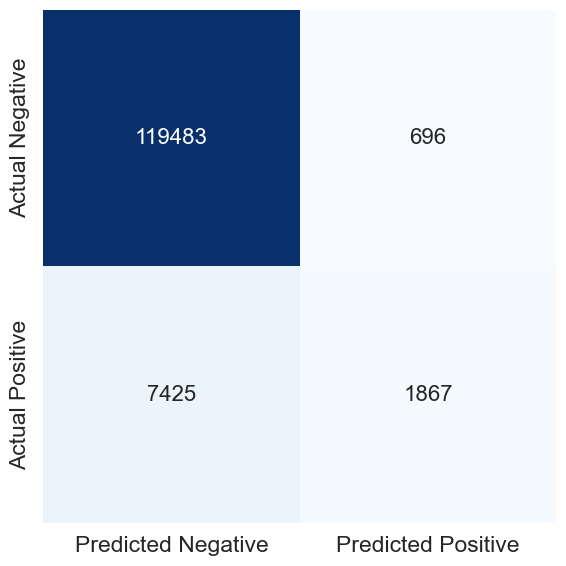

In [81]:
def conf_matrix(y_test, pred_test_binary):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test_binary)
    con_mat = pd.DataFrame(con_mat, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.tight_layout()

conf_matrix(y_test_adjusted, pred_test_binary)

In [82]:
def score(reference_score, PDO, odds_at_reference_score, PD): 
    Factor = PDO/np.log(2)
    Offset = reference_score - Factor * np.log(odds_at_reference_score)
    Score = Offset + Factor*np.log(PD/(1-PD))
    return score, plt.hist(Score)

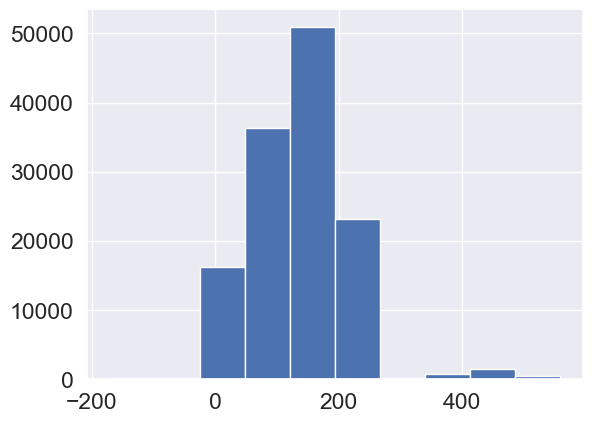

In [84]:
score, plot = score(600, 50, 30, pred_test_logit['1'])

### 2. Model Validation

#### 2.1 P-value

In [85]:
import statsmodels
import statsmodels.api as sm 

X = train_WOE[['int_rate_binned_woe', 'tot_coll_amt_binned_woe', 'purpose_woe', 'annual_inc_binned_woe', 'home_ownership_woe', 'addr_state_woe', 'emp_length_woe']]
y = y_train_adjusted
# building the model and fitting the data 
X_added_constant = sm.add_constant(X)
log_reg = sm.Logit(y, X_added_constant).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.211155
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               517849
Model:                          Logit   Df Residuals:                   517841
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Oct 2024   Pseudo R-squ.:                  0.1823
Time:                        08:53:07   Log-Likelihood:            -1.0935e+05
converged:                       True   LL-Null:                   -1.3373e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.5687      0.006   -408.735      0.000      -2.581      -2.556
int_rate_binned_woe        -1.0019      0.009   -106.336      0.000      -1.020      -0.983
tot_coll_amt_binned_woe    -0.9925      0.006   -156.980      0.000      -1.005      -0.980
purpose_woe                -0.1416      0.021     -6.843      0.000      -0.182      -0.101
annual_inc_binned_woe      -0.6302      0.023    -27.504      0.000      -0.675      -0.585
home_ownership_woe         -0.3594      0.036    -10.113      0.000      -0.429      -0.290
addr_state_woe             -0.7822      0.039    -20.318      0.000      -0.858      -0.707
emp_length_woe             -0.6386      0.045    -14.187      0.000      -0.727      -0.550
===========================================================================================
"""

=> Since there no variable having P-value over 0.05, so all of the variables are significant

## Apply Machine Learning

### 1. Class Weights

In [87]:
def GridSearch_for_Gini(x_set, y_set, steps):
    lr = LogisticRegression(solver='newton-cg', random_state = 0)
    
    #Setting the range for class weights
    weights = np.linspace(0.0,0.99,steps)
    
    #Creating a dictionary grid for grid search
    param_grid = {'class_weight': [{0:1-x, 1:x} for x in weights]}
    
    #Fitting grid search to the train data with 5 folds
    gridsearch = GridSearchCV(estimator= lr, 
                              param_grid= param_grid,
                              cv=StratifiedKFold(), 
                              n_jobs=-1, 
                              scoring='roc_auc', 
                              verbose=2).fit(x_set, y_set)
    

    # Tạo bảng kết quả gridsearch gồm weights và scores
    weigh_data = pd.DataFrame({'score': gridsearch.cv_results_['mean_test_score'], 'weight': weights})
    #Ploting the results
    sns.set_style('whitegrid')
    plt.figure(figsize=(9,6))
    plot = sns.lineplot(x = weigh_data['weight'], y = weigh_data['score'])  # set x-axis là weight, y-axis là score
    plt.xlabel('Weight for class 1')
    plt.ylabel('AUC score')
    plt.xticks([round(i/10,1) for i in range(0,11,1)])
    plt.title('Scoring for different class weights', fontsize=24)
    return plot

Fitting 5 folds for each of 20 candidates, totalling 100 fits


<AxesSubplot: title={'center': 'Scoring for different class weights'}, xlabel='Weight for class 1', ylabel='AUC score'>

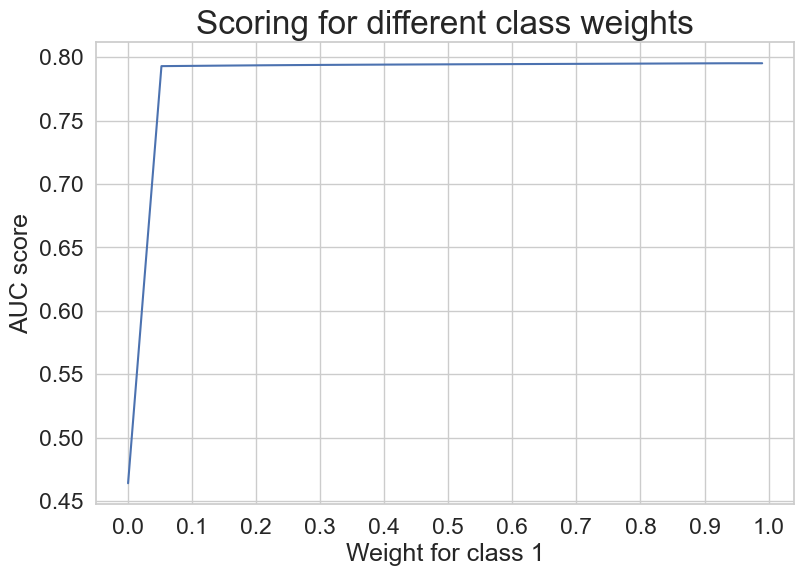

In [88]:
GridSearch_for_Gini(train_WOE, y_train_adjusted, 20)

No need to put higher class weights to minority class

### 2. Random Forest Classifier

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [37]:
from sklearn.model_selection import train_test_split
target = 'loan_status'
model_features = list(set(df.columns).difference({target}))

X = df[model_features]
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42, stratify=df['loan_status'])

In [38]:
# Deal with missing values
x_train['emp_length'].fillna('< 1 year', inplace = True)   #employent length takes missing value since those customers possibly have no job at that time
x_train['tot_coll_amt'].fillna(0, inplace = True)
x_train['tot_cur_bal'].fillna(0, inplace = True)

x_test['emp_length'].fillna('< 1 year', inplace = True)
x_test['tot_coll_amt'].fillna(0, inplace = True)
x_test['tot_cur_bal'].fillna(0, inplace = True)


In [39]:
from sklearn.preprocessing import LabelEncoder

cat_var=x_train.select_dtypes(include=["object"]).columns
label_encoder = LabelEncoder()
for column in cat_var:
    label_encoder.fit(x_train[column])
    x_train[column] = label_encoder.transform(x_train[column])
    x_test[column] = label_encoder.transform(x_test[column])

In [40]:
from sklearn.ensemble import RandomForestClassifier

#Regression
rfc = RandomForestClassifier(max_depth=10, random_state=42) 
rfc.fit(x_train, y_train)           
    
# Predicting on the train data
pred_test_on_train = rfc.predict_proba(x_train)
pred_test_on_train = pd.DataFrame(pred_test_on_train,
                         columns = ['0', '1'])      # Create table of estimated results
#Calculating and printing the f1 score 
gini_score_train = 2*roc_auc_score(y_train, pred_test_on_train['1']) - 1

pred_test_on_test = rfc.predict_proba(x_test)
pred_test_on_test = pd.DataFrame(pred_test_on_test,
                         columns = ['0', '1'])      # Create table of estimated results
#Calculating and printing the f1 score 
gini_score_test = 2*roc_auc_score(y_test, pred_test_on_test['1']) - 1

print(f'gini score on train set is: {gini_score_train}')
print(f'gini score on test set is: {gini_score_test}')

gini score on train set is: 0.8245586117712245
gini score on test set is: 0.8027700046896158


Random Forest shows an outstanding model performance compared to Logistic Regression

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
import pandas as pd

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 20],
    'min_samples_leaf': [4, 8],
    'bootstrap': [True, False]
}

# RandomForestClassifier with GridSearchCV
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Best model after tuning
best_rfc = grid_search.best_estimator_

# Predicting on the train data
pred_test = best_rfc.predict_proba(x_train)
pred_test = pd.DataFrame(pred_test, columns=['0', '1'])  # Table of probabilities


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [44]:
# Calculating Gini score
gini_score = 2 * roc_auc_score(y_train, pred_test['1']) - 1

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Gini Score: {gini_score:.4f}')


Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 200}
Gini Score: 0.9403


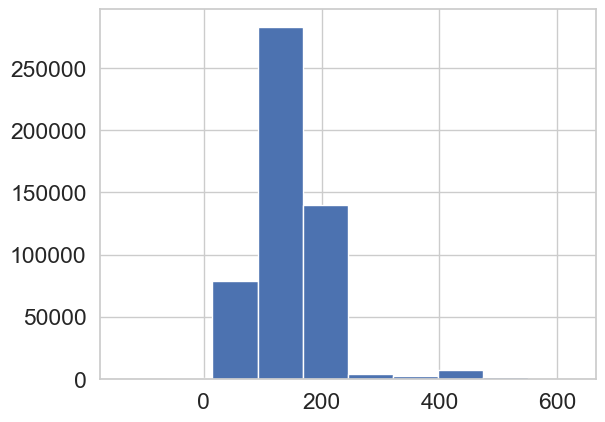

In [89]:
score, plot = score(600, 50, 30, pred_test['1'])